In [231]:
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
import imageio

from IPython.display import clear_output

In [232]:
rang = 3

In [233]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=64, recur=20):
        super(SimpleRNN, self).__init__()
        self.in_lin = nn.Linear(input_size, hidden_size)
        self.repeat = nn.Linear(hidden_size, hidden_size)
        self.out_lin = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
        self.recur = recur
    
    def forward(self, x):
        h = self.act(self.in_lin(x))
        for _ in range(self.recur):
            h = self.act(self.repeat(h))
        return self.out_lin(h)


In [234]:
def create_frame(t, allx, pred_y, trainl, testl, show=False):
    plt.figure(figsize=(25, 3))

    plt.plot(allx, pred_y, 'bo')
    
    plt.xlim([0,rang])
    plt.xlabel('x', fontsize = 14)
    plt.ylim([-2,2])
    plt.ylabel('y', fontsize = 14)
    plt.title(f'epoch {t}, train loss: {trainl:.4f}, test loss: {testl:.4f}',
              fontsize=14)
    if show:
        plt.show()
    else:
        plt.savefig(f'./img/img_{t}.png', 
                    transparent = False,  
                    facecolor = 'white'
                )    
        plt.close()

In [235]:
def datgen(bs, mid, fre, train = True):
    if train:
        datx = t.cat([t.rand(bs, 1) * (rang * (1-mid) / 2), (rang * (1-mid) / 2) + (mid * rang) + t.rand(bs, 1) * (rang * (1-mid) / 2)], dim=0)
        daty = t.sin(fre * datx)
    else:
        datx = t.rand(bs, 1) * rang
        daty = t.sin(fre * datx)
    return datx, daty

In [236]:
batch_size = 8192

freq = 100
middle = 1/8

In [237]:
x_all, y_all = datgen(batch_size + int(batch_size * middle), middle, freq, train = False)

px_all = t.squeeze(x_all).cpu().numpy()
py_all = t.squeeze(y_all).cpu().numpy()

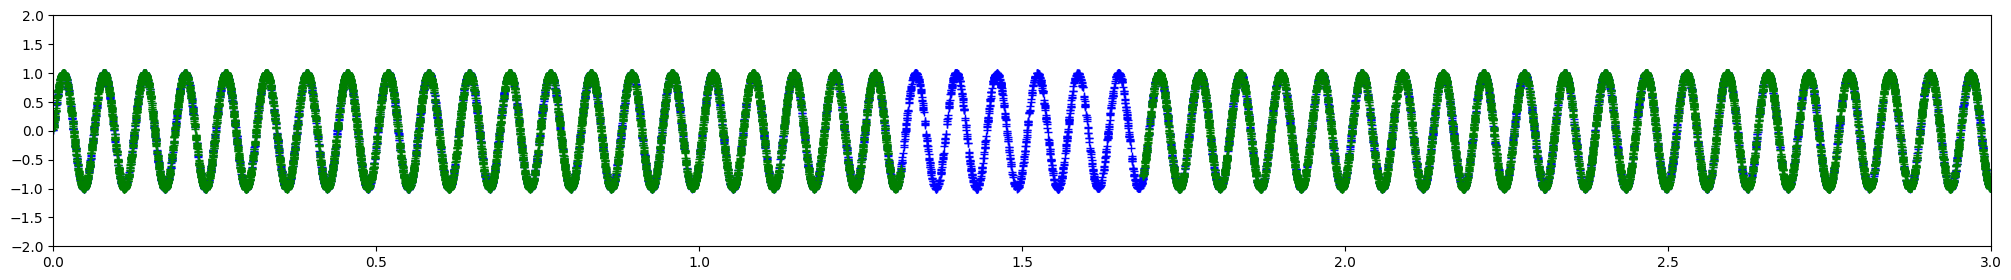

In [238]:
samplex, sampley = datgen(batch_size, middle, freq)

plt.figure(figsize=(25,3))
plt.xlim([0, rang])
plt.ylim([-2,2])
plt.plot(px_all, py_all, 'b+')
plt.plot(t.squeeze(samplex).cpu().numpy(), t.squeeze(sampley).cpu().numpy(), 'g+')
plt.show()

In [239]:
simple_rnn = SimpleRNN(hidden_size=8, recur=int(1/3.14*freq))
optimizer = t.optim.SGD(simple_rnn.parameters(), lr=0.01)
loss_fn = t.nn.MSELoss()


In [240]:
train_losses = []
test_losses = []
pred_t = []

In [241]:
start = 0
steps = 80000

frames = 150
interval = steps//frames
for i in range(start, steps):
    x_train, y_train = datgen(batch_size, middle, freq)

    optimizer.zero_grad()
    y_pred = simple_rnn(x_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if i % 150 == 0:
        clear_output(wait=True)
        print(round(i/steps*100, 3), '%')
        with t.no_grad():
            p_all = simple_rnn(x_all)
            test_loss = loss_fn(p_all, y_all)

            train_losses.append(loss.item())
            test_losses.append(test_loss.item())

            y_points = p_all.cpu().numpy()
            pred_t.append(y_points)


6.562 %


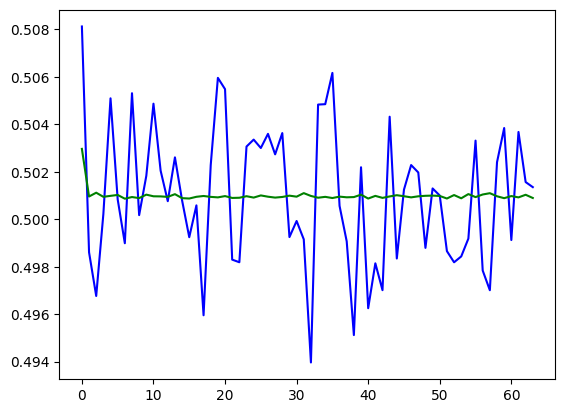

In [208]:
plt.plot(train_losses, label='train loss', color='green')
plt.plot(test_losses, label='test loss', color='blue')
plt.show()


In [23]:
for i, pred in enumerate(pred_t):
    create_frame(i, px_all, pred, train_losses[i], test_losses[i])

In [24]:
frames = []
for ti in range(len(pred_t)):
    image = imageio.v2.imread(f'./img/img_{ti}.png')
    frames.append(image)

In [25]:
imageio.mimsave('./rnn.gif', frames, fps = 30)